In [1]:
import geopandas as gpd
import pandas as pd
import GOSTnets as gn
import networkx as nx
import osmnx as ox
from shapely.geometry import Point
from shapely.geometry import box
from shapely.wkt import loads
import numpy as np

In [2]:
cd /home/op/network_manila

/home/op/network_manila


In [3]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [4]:
#G_clip = nx.read_gpickle('data_osm_raw/manila_clean_clipped.pickle')

In [5]:
G_disrupted = nx.read_gpickle('data_osm_raw/manila_clean_disrupted.pickle')

## prepare origin and destination points

In [5]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]

In [215]:
manila = manila.to_crs(crs_manila)

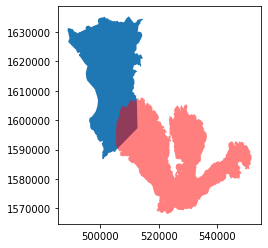

In [217]:
#exclude laguna area from the manila boundary, as we do not care about trips from within the lake
laguna = gpd.read_file("boundaries/laguna_de_bay_osm.geojson")
laguna = laguna.to_crs(crs_manila)
ax= manila.plot()
laguna.plot(ax=ax, color="red", alpha=0.5)

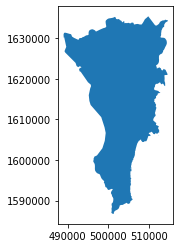

In [219]:
manila_nolaguna = gpd.overlay(manila, laguna, how='difference')
manila_nolaguna.plot()

In [7]:
def create_point_grid(gdf, distance, crs):
    """
    this function creates a grid of points with equal distance within the space described by the geodataframe
    important: the crs passed as param has to be in accordance with the distance specified
    :param gdf: a geodataframe
    :param distance: distance between points. measured in crs of gdf
    :param crs: the crs in which the distance is measured to return the points
    :returns: a geodataframe of points
    """

    gdf_copy = gdf.copy()
    gdf_copy = gdf_copy.to_crs(crs)
    minx, miny, maxx, maxy = gdf_copy.bounds.values[0]
    poly = gdf_copy.unary_union
    x = minx
    points = []
    while x < maxx:
        y = miny
        while y < maxy:
            point = Point(x,y)
            #check whether point is within poly and keep only if this is the case
            if poly.intersects(point):
                points.append(point)
            y = y + distance
        x = x + distance
    df = pd.DataFrame({'geometry':points})  
    points_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs)
    return points_gdf

In [8]:
box_geom = box(121.05, 14.6, 121.1, 14.65)
df = pd.DataFrame({"geometry":box_geom}, index=[0])
box_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs_global)

In [220]:
#create point grid
origin_points = create_point_grid(manila_nolaguna, distance = 500, crs = crs_manila)

In [221]:
origin_points = origin_points.to_crs(crs_global)
manila = manila.to_crs(crs_global)
laguna = laguna.to_crs(crs_global)


In [222]:
hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")
schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")

#hospitals = hospitals[hospitals.intersects(box_gdf.unary_union)]

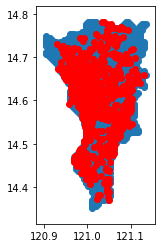

In [223]:
ax = origin_points.plot()
hospitals.plot(ax = ax, color='red')

## bind points to graph 

In [224]:
origins_snapped = gn.pandana_snap(G_disrupted, 
                                  origin_points, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1605: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
/home/op/anaconda3/envs/network_manila/lib/python3.6/site-packages/GOSTnets-0.1.2-py3.6.egg/GOSTnets/core.py:1607: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [ ]:
hospitals_snapped = gn.pandana_snap(G_disrupted, 
                                  hospitals, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [ ]:
schools_snapped = gn.pandana_snap(G_disrupted, 
                                  schools, 
                                  source_crs='epsg:4326',
                                  target_crs='epsg:3123', 
                                  add_dist_to_node_col = True)




In [ ]:
origins_snapped.to_csv("asset_data/origins_snapped.csv")
hospitals_snapped.to_csv("asset_data/hospitals_snapped.csv")
schools_snapped.to_csv("asset_data/schools_snapped.csv")

In [ ]:
origins_snapped = pd.read_csv("asset_data/origins_snapped.csv", dtype = {"NN":"str", "NN_dist": "float64"})
hospitals_snapped = pd.read_csv("asset_data/hospitals_snapped.csv", dtype = {"NN":"str", "NN_dist": "float64"})
schools_snapped = pd.read_csv("asset_data/schools_snapped.csv", dtype = {"NN":"str", "NN_dist": "float64"})


origins_snapped['geometry'] = origins_snapped['geometry'].apply(loads)
hospitals_snapped['geometry'] = hospitals_snapped['geometry'].apply(loads)
schools_snapped['geometry'] = schools_snapped['geometry'].apply(loads)

origins_snapped = gpd.GeoDataFrame(origins_snapped, 
                                   geometry="geometry", crs = crs_global)
hospitals_snapped = gpd.GeoDataFrame(hospitals_snapped, 
                                   geometry="geometry", crs = crs_global)
schools_snapped = gpd.GeoDataFrame(schools_snapped, 
                                   geometry="geometry", crs = crs_global)



## calculate origin, destination matrices

In [ ]:
def quickfix_dtypes(list):
    
    #when saving and re-importing the snapped points as csv, the data types get messed up
    # this is the case because the IDs of the Graph nodes can have either ints or str as IDs
    # if they are strings, then they start with "new_obj", else they are an integeß number

    #this is likely a relic of gn.simplify_junctions -> address at some point
    
    
    list_copy = list.copy()
    list_return = []
    for entry in list_copy:
        if entry.startswith("new_obj"):
            list_return.append(str(entry))
        else:
            list_return.append(int(entry))
            
    return list_return

In [ ]:
def calculate_OD_with_startend(G, origins_gdf, destinations_gdf, walk_speed = (4.5/3.6),
                               fail_value = 999999999, weight_column = 'time', weighted_origins = False):
    """
    this function wraps around gn.calculate_OD and adds times to walk from the origin point to the first node
    and from the last node to the destination (off-network)    
    :param G: a graph object
    :param origins_gdf: the output of binding a list of origin points to G using gn.pandana_snap with
            parameter add_dist_to_node_col = True
    :param destinations_gdf: the output of binding a list of destination points to G using gn.pandana_snap
            with parameter add_dist_to_node_col = True
    :param walk_speed: a number, the speed at which to walk off-network. has to be in unit corrseponding to the
            Graphs "time" column used by gn.panadana_snap
    :param fail_value: a number, fail value passed to gn.calculate_OD
    :param weight_column: a string, weight_column passed to gn.calculate_OD
    :param weighted_origins: boolean, weighted_origins value passed to gn.calculate_OD

    :returns: a OD matrix (as numpy matrix) containing the distance from origin points (rows) to destination points (columns)
    """

    
    #convert origins and destinations to list of nodes
    origin_nodes = quickfix_dtypes(list(origins_gdf.NN))
    destination_nodes = quickfix_dtypes(list(destinations_gdf.NN))
    
    #calculate OD matrix between start and end nodes, in unit of "time"
    OD = gn.calculate_OD(G, origins= origin_nodes, destinations = destination_nodes, 
                         fail_value = fail_value, weight = weight_column, 
                         weighted_origins = weighted_origins)

    ## add time to walk from origin point to nearest node
    distance_to_node = np.asarray(origins_gdf.NN_dist)[:, np.newaxis]
    time_to_node = distance_to_node * walk_speed
    #each row of OD matrix is from same origin, so we can just use numpy's broadcasting
    OD = OD + time_to_node
    
    ## add time to walk from destination node to POI
    distance_from_node = np.asarray(destinations_gdf.NN_dist)[:, np.newaxis]
    time_from_node = distance_from_node * walk_speed
    #each column of OD matrix is same destination, so we transpose times and then add using numpy's broadcasting
    OD = OD + time_from_node.T
    
    return OD


### OD for hospital trips

In [ ]:
OD_hospitals = calculate_OD_with_startend(G_disrupted, origins_snapped, hospitals_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time', 
                                weighted_origins = False)


In [ ]:
OD_hospitals_disrupted = calculate_OD_with_startend(G_disrupted, origins_snapped, hospitals_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time_disrupted', 
                                weighted_origins = False)


In [ ]:
OD_hospitals.shape , OD_hospitals_disrupted.shape

In [ ]:
min_distance_hospitals = np.min(OD_hospitals, axis = 1)
min_distance_hospitals_disrupted = np.min(OD_hospitals_disrupted, axis = 1)

origin_points['min_hospital_distance_seconds'] = min_distance_hospitals
origin_points['min_hospital_distance_seconds_disrupted'] = min_distance_hospitals_disrupted

#replace fail values with NAN

#replace fail values with NAN
origin_points.loc[origin_points['min_hospital_distance_seconds'] > 99999999, 
                  'min_hospital_distance_seconds'] = np.NaN

origin_points.loc[origin_points['min_hospital_distance_seconds_disrupted'] > 99999999, 
                  'min_hospital_distance_seconds_disrupted'] = np.NaN

### OD for school trips

In [ ]:
OD_schools = calculate_OD_with_startend(G_disrupted, origins_snapped, schools_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time', 
                                weighted_origins = False)


In [ ]:
OD_schools_disrupted = calculate_OD_with_startend(G_disrupted, origins_snapped, schools_snapped, 
                                walk_speed = 4.5/3.6, fail_value = 999999999, weight_column = 'time_disrupted', 
                                weighted_origins = False)


In [ ]:
OD_schools.shape , OD_schools_disrupted.shape

In [ ]:
min_distance_schools = np.min(OD_schools, axis = 1)
min_distance_schools_disrupted = np.min(OD_schools_disrupted, axis = 1)

origin_points['min_school_distance_seconds'] = min_distance_schools
origin_points['min_school_distance_seconds_disrupted'] = min_distance_schools_disrupted

#replace fail values with NAN
origin_points.loc[origin_points['min_school_distance_seconds'] > 99999999, 
                  'min_school_distance_seconds'] = np.NaN

origin_points.loc[origin_points['min_school_distance_seconds_disrupted'] > 99999999, 
                  'min_school_distance_seconds_disrupted'] = np.NaN

In [388]:
origin_points["increase_hospital_sec"] = (origin_points["min_hospital_distance_seconds_disrupted"] -
                                          origin_points["min_hospital_distance_seconds"])
origin_points["increase_hospital_perc"] = (origin_points["increase_hospital_sec"] /
                                           origin_points["min_hospital_distance_seconds"])*100



hospitaltrip_possible = (origin_points['min_hospital_distance_seconds'].isnull()==False)
hospitaltrip_impossible_afterdisrupt = (origin_points['min_school_distance_seconds_disrupted'].isnull()==True)
origin_points["hospitaltrip_impossible_onlyafterdisrupt"] = np.where(
    (hospitaltrip_possible&hospitaltrip_impossible_afterdisrupt), 1, 0)



origin_points["increase_school_sec"] = (origin_points["min_school_distance_seconds_disrupted"] -
                                        origin_points["min_school_distance_seconds"])
origin_points["increase_school_perc"] = (origin_points["increase_school_sec"] /
                                        origin_points["min_school_distance_seconds"])*100

schooltrip_possible = (origin_points['min_school_distance_seconds'].isnull()==False)
schooltrip_impossible_afterdisrupt = (origin_points['min_school_distance_seconds_disrupted'].isnull()==True)
origin_points["schooltrip_impossible_onlyafterdisrupt"] = np.where(
    (schooltrip_possible&schooltrip_impossible_afterdisrupt), 1, 0)


### save


In [389]:
origin_points.to_file("asset_data/origin_points_results.geojson", driver='GeoJSON')

In [503]:
#as csv
origin_points.to_csv("asset_data/origin_points_results.csv")


In [504]:
# also move to outputfolder
origin_points.to_file("output/origin_points_results.geojson", driver='GeoJSON')
origin_points.to_csv("output/origin_points_results.csv")


## visualize results

In [8]:
from matplotlib import pyplot as plt

In [6]:
origin_points = gpd.read_file("asset_data/origin_points_results.geojson")

In [10]:
#import hazard data and asset data for plotting

liquefaction = gpd.read_file(r"hazard_data/Liquefaction/Liquefaction_MetroManila.shp")
faultline = gpd.read_file(r"hazard_data/ActiveFault/ActiveFault_MetroManila.shp")

hospitals = gpd.read_file(r"asset_data/MetroManila/MetroManila/DOH/HealthFacilities.shp")
schools = gpd.read_file(r"asset_data/MetroManila/MetroManila/DepEd/SchoolLocation.shp")


In [12]:
highways_to_keep = ["motorway", "motorway_link", "trunk", "trunk_link" "primary", "primary_link",
                   "secondary", "secondary_link", "tertiary", "tertiary_link"]

G_main = G_disrupted.copy()
edges_to_remove = [(u,v) for  (u,v,attr) in G_main.edges(data=True) if not attr['infra_type'] in highways_to_keep]
G_main.remove_edges_from(edges_to_remove)
G_main.remove_nodes_from(list(nx.isolates(G_main)))

In [13]:
G_main_gdf = gn.edge_gdf_from_graph(G_main)

In [14]:
G_gdf = gn.edge_gdf_from_graph(G_disrupted)

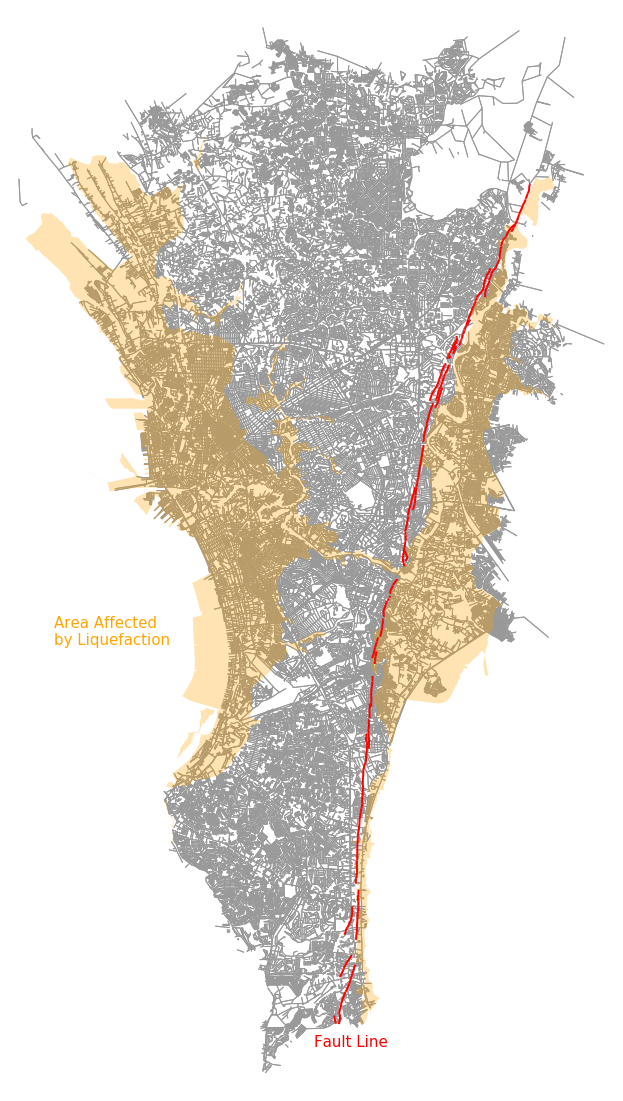

<Figure size 432x288 with 0 Axes>

In [442]:
G_disrupted.graph.update( {'crs' : crs_global} )
G_disrupted.graph.update( {'name' : 'manila'} )
fig, ax = ox.plot_graph(G_disrupted, fig_height=20, axis_off=True, show=False, node_color="None")
plot_fl = faultline.plot(ax=ax, color='red', linewidth=2, zorder=3, label="Fault Line", legend=True)
plot_lq = liquefaction.plot(ax=ax, color='orange', markersize=10, zorder=2, alpha=0.3)
ax.text(120.92,14.53, "Area Affected \nby Liquefaction", fontsize=15, color='orange')
ax.text(121.03,14.36, "Fault Line", fontsize=15, color='red')
fig.savefig("output/roads_hazards.png", dpi = 400)
fig

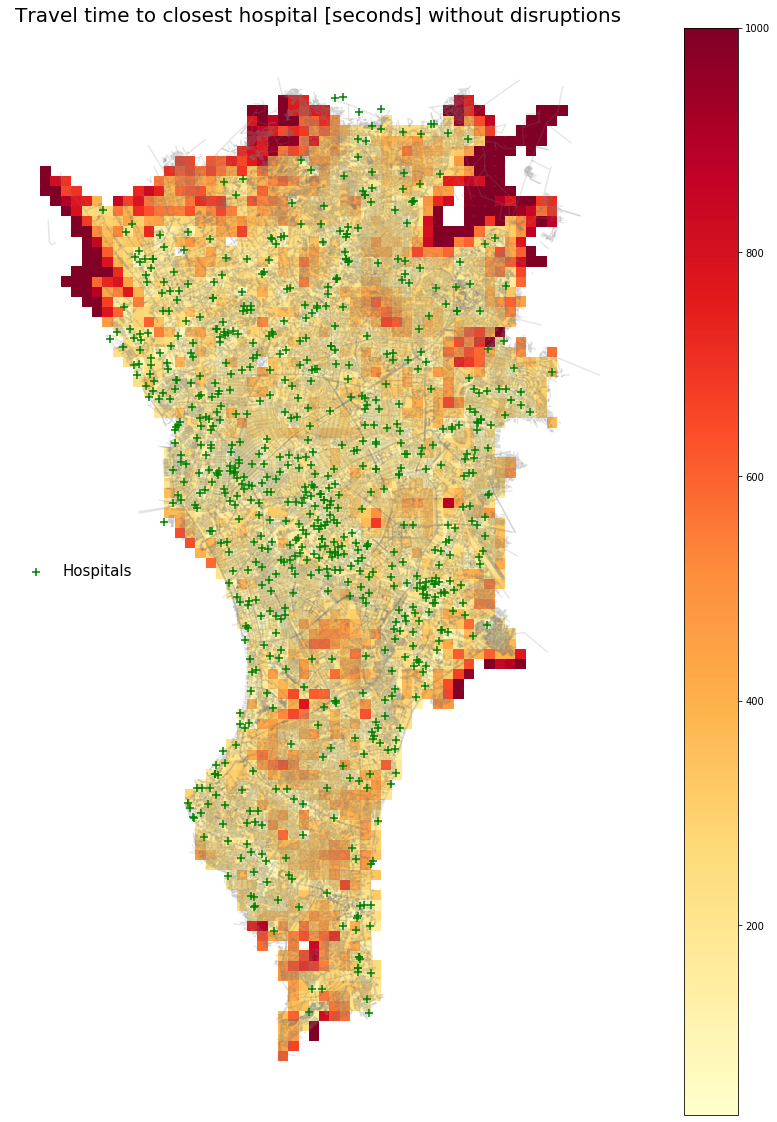

In [31]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(
    ax=ax, cmap="YlOrRd", column="min_hospital_distance_seconds", vmax = 1000,
    marker = "s", markersize=90, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="Green", marker="+", markersize=50, zorder=2, label="Hospitals")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Travel time to closest hospital [seconds] without disruptions", fontsize=20)
ax.set_axis_off()
fig.savefig("output/hospitaltrips_sec.png", dpi = 400)


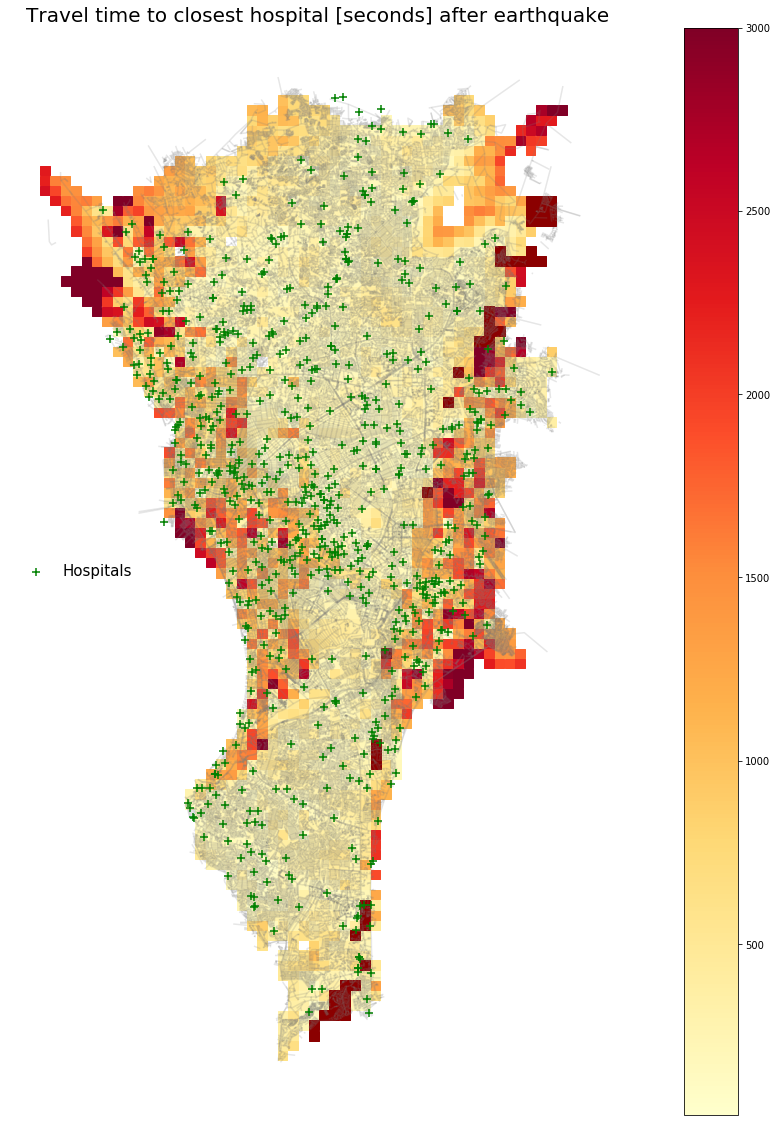

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(
    ax=ax, cmap="YlOrRd", column="min_hospital_distance_seconds_disrupted",  vmax = 3000,
    marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.hospitaltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="Green", marker="+", markersize=50, zorder=2, label="Hospitals")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Travel time to closest hospital [seconds] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/hospitaltrips_disrupted_sec.png", dpi = 400)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(
    ax=ax, cmap="YlOrRd", column="min_school_distance_seconds", vmax = 1200,
    marker = "s", markersize=90, zorder=-1, legend=True)
schools.plot(ax = ax, color="Green", marker="o", markersize=20, zorder=2, label="Schools")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Travel time to closest school [seconds] without disruptions", fontsize=20)
ax.set_axis_off()
fig.savefig("output/schooltrips_sec.png", dpi = 400)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(
    ax=ax, cmap="YlOrRd", column="min_school_distance_seconds_disrupted",  vmax = 3000,
    marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.schooltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
schools.plot(ax = ax, color="Green", marker="o", markersize=20, zorder=2, label="Schools")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Travel time to closest school [seconds] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/schooltrips_disrupted_sec.png", dpi = 400)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(ax=ax, cmap="YlOrRd", column="increase_hospital_sec", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.hospitaltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="Green", marker="+", markersize=50, zorder=2, label="Hospitals")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Increase in travel time to closest hospital [seconds] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/hospitaltrips_increase_sec.png", dpi = 400)


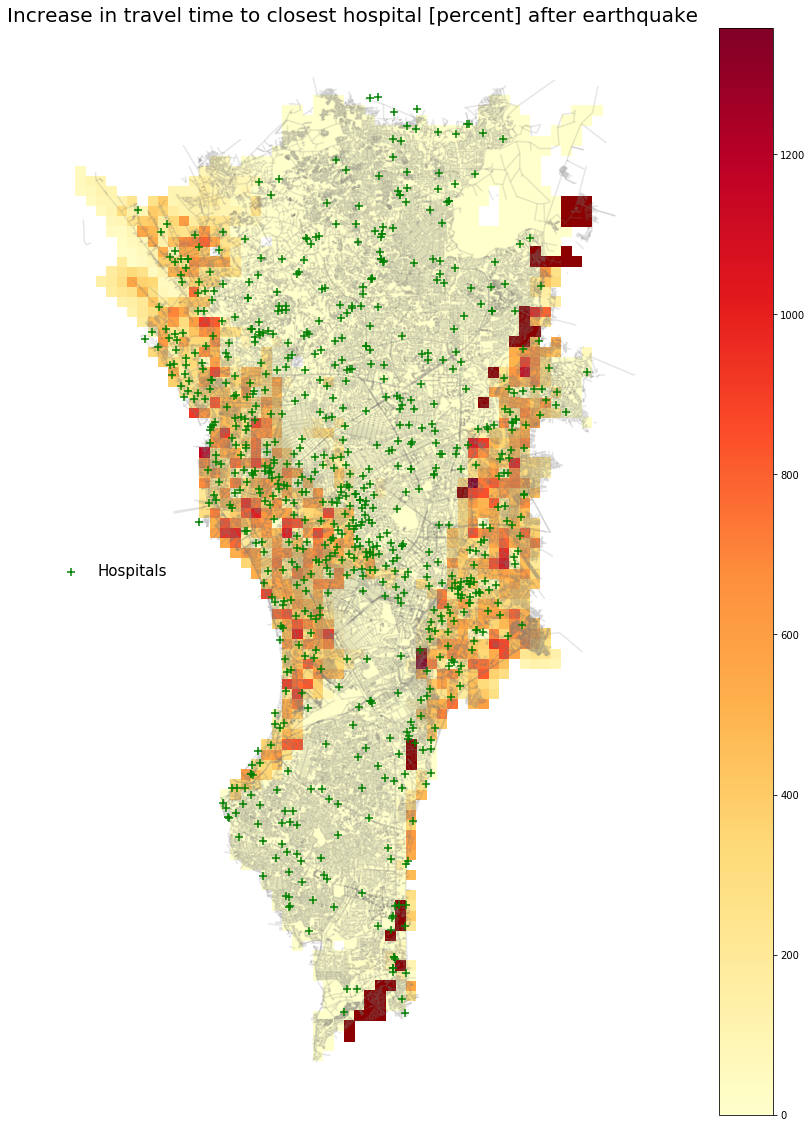

In [459]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(ax=ax, cmap="YlOrRd", column="increase_hospital_perc", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.hospitaltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
hospitals.plot(ax = ax, color="Green", marker="+", markersize=50, zorder=2, label="Hospitals")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)

ax.set_title("Increase in travel time to closest hospital [percent] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/hospitaltrips_increase_perc.png", dpi = 400)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(ax=ax, cmap="YlOrRd", column="increase_school_sec", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.schooltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
schools.plot(ax = ax, color="Green", marker="o", markersize=20, zorder=2, label="Schools")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)
ax.set_title("Increase in travel time to closest school [seconds] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/schooltrips_increase_sec.png", dpi = 400)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
origin_points.plot(ax=ax, cmap="YlOrRd", column="increase_school_perc", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
origin_points[origin_points.schooltrip_impossible_onlyafterdisrupt==1].plot(ax=ax, color="DarkRed", 
                   marker = "s", markersize=90, zorder=-1, legend=True)
schools.plot(ax = ax, color="Green", marker="o", markersize=20, zorder=2, label="Schools")
G_gdf.plot(ax = ax, color="Grey", zorder=1, alpha = 0.1)
ax.legend(loc='center left',
          fontsize=15,
          frameon=False)
ax.set_title("Increase in travel time to closest school [percent] after earthquake", fontsize=20)
ax.set_axis_off()
fig.savefig("output/schooltrips_increase_perc.png", dpi = 400)


In [465]:
import seaborn as sns

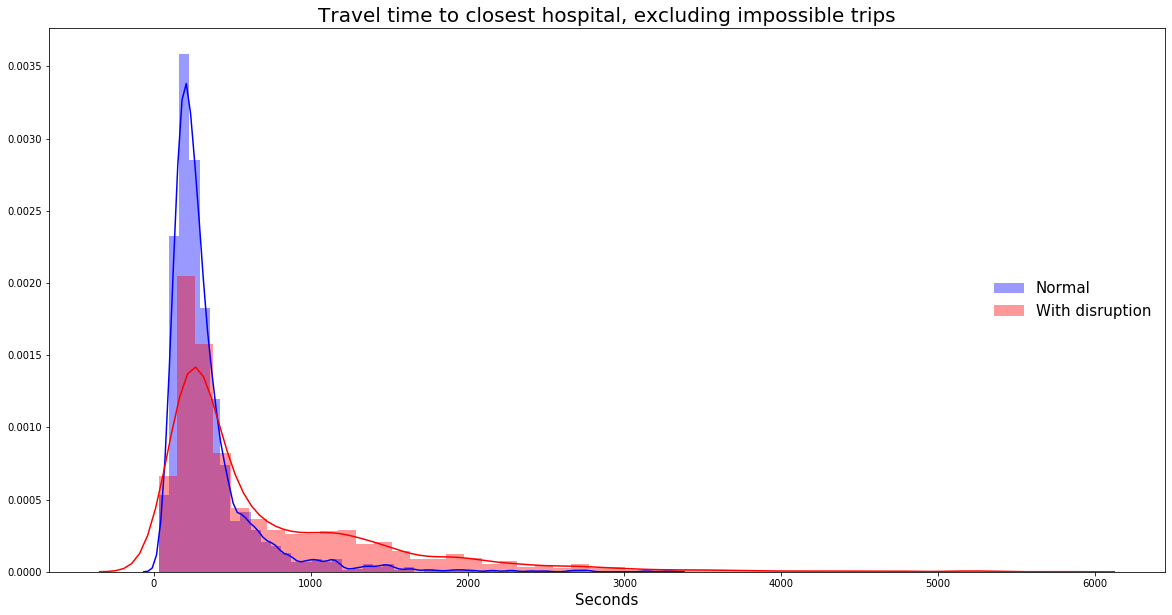

In [500]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot( origin_points["min_hospital_distance_seconds"].dropna(), color="blue", 
             label="Normal", ax=ax)
sns.distplot(origin_points["min_hospital_distance_seconds_disrupted"].dropna(), color="red", 
             label="With disruption", ax =ax)
ax.legend(loc='center right',
          fontsize=15,
          frameon=False)
ax.set_title("Travel time to closest hospital, excluding impossible trips", fontsize = 20)
ax.set_xlabel("Seconds", fontsize = 15)
ax.set_xlabel("Seconds", fontsize = 15)
ax.figsize=(20,20)
fig.savefig("output/hist_hospitaltrips.png", dpi = 400)
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot( origin_points["min_school_distance_seconds"].dropna(), color="blue", 
             label="Normal", ax=ax)
sns.distplot(origin_points["min_school_distance_seconds_disrupted"].dropna(), color="red", 
             label="With disruption", ax =ax)
ax.legend(loc='center right',
          fontsize=15,
          frameon=False)
ax.set_title("Travel time to closest school, excluding impossible trips", fontsize = 20)
ax.set_xlabel("Seconds", fontsize = 15)
ax.set_xlabel("Seconds", fontsize = 15)
ax.figsize=(20,20)
fig.savefig("output/hist_schooltrips.png", dpi = 400)
fig.show()